# Статистика, прикладной поток
## Практическое задание 6

В данном задании вы исследуете некоторые свойства непараметрических методов, а также проверки статистических гипотез.

**Правила:**

* Дедлайн **2 декабря 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[applied] Фамилия Имя - задание 6"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  2 балла **O3**
* Задача 2 -  10 баллов **O2**
* Задача 3 -  5 баллов **O3**
* Задача 4 -  5 баллов **O3**
* Задача 5 -  5 баллов **O3**
* Задача 6 -  12 баллов **O3**
* Задача 7 -  20 баллов **O3**
* Задача 8 -  15 баллов **O3**

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from statsmodels.nonparametric.kde import kernel_switch, KDEUnivariate
from statsmodels.distributions.empirical_distribution import ECDF

warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

## Непараметрический подход

__________________
### Задача 1.

Напишите определение ядра, используемого для построения ядерных оценок плотности.

** Определение: ** 
Пусть $\mathbf{X} = (X_1, ..., X_n)$ - выборка из произвольного распределения $P \in \mathscr{P}$, где $\mathscr{P}=\{\text{все абсолютно-непрерывные распределения}\}$.
Рассмотрим $X_1$ - в её окрестности плотность положительна. Оценим плотность, как :
$$\widetilde{p_1}(x) = \frac{1}{h}q\left(\frac{x-X_1}{h}\right)$$
* $q$ - симметричная непрерывная известная плотность - *ядро*
* $h$ - ширина ядра, параметр масштаба

Прежде чем начать работу с ядерными оценками плотности, изучим виды ядер. В библиотеке `statsmodels` реализованы следующие ядра:

In [2]:
list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']

Нарисуем эти ядра. Запустите код в ячейке.

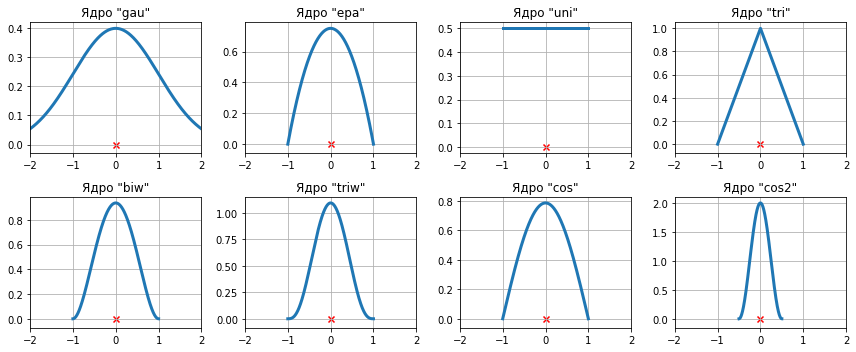

In [3]:
fig = plt.figure(figsize=(12, 5))

for i, (ker_name, ker_class) in enumerate(kernel_switch.items()):
    
    kernel = ker_class()  # ядро
    domain = kernel.domain or [-2, 2]  # носитель
    x_vals = np.linspace(*domain, 2**10)
    y_vals = kernel(x_vals)

    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Ядро "{}"'.format(ker_name))
    ax.plot(x_vals, y_vals, lw=3, label='{}'.format(ker_name))
    ax.scatter([0], [0], marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim((-2, 2))
    
plt.tight_layout()

Посморим, как будет выглядеть ядерная оценка плотности в зависимости от типа ядра, взяв в качестве реализации выборки набор точек [-1, 0, 1]. Запустите код в ячейке.

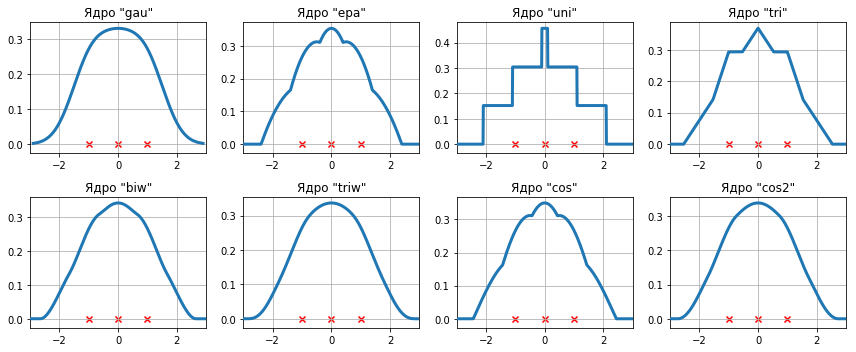

In [4]:
data = np.linspace(-1, 1, 3)  # выборка
kde = KDEUnivariate(data)  # объект, выполняющий построение оценки

fig = plt.figure(figsize=(12, 5))

for i, kernel in enumerate(kernel_switch.keys()):
    
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Ядро "{}"'.format(kernel))
    
    # построение ядерной оценки плотности с заданным ядром
    kde.fit(kernel=kernel, fft=False, gridsize=2**10)
    # отрисовка полученной оценки
    ax.plot(kde.support, kde.density, lw=3, zorder=10)
    # отрисовка выборки
    ax.scatter(data, np.zeros_like(data), marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim([-3, 3])
    
plt.tight_layout()

Какие вы можете назвать преимущества и недостатки для первых трех ядер как с точки зрения самой оценки плотности, так и с вычислительной точки зрения?

**Преимущества:**
* Гауссово ядро: получается довольно гладким
* Ядро Епанечникова: даёт сильный рост рядом с элементами выборки
* Равномерное ядро: даёт константный рост от одного элемента выборки к другому и легко вычисляется

**Недостатки:**
* Гауссово ядро: концентрирует всю плотность в центре
* Ядро Епанечникова: не гладкое
* Равномерное ядро: Казалось бы выборка $[-1, 0, 1]$ похожа на равномерное раcпределение, но ядерная плотность не выглядит как плотность равномерного

Другие примеры работы с ядерными оценками плотности можно посмотреть по ссылке http://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html

__________________
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики $$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле? 

Для выполнения задания можно использовать следующую функцию:

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
# help(ECDF)  # В случае затрудн1ений раскомментировать и выполнить

Определим вспомогательные функции:

In [7]:
# Функция распределения стандартного нормального
def F(x):
    return sps.norm.cdf(x)

# Функции \widehat{F}_n(x) для всех n
def F_n(x, sample, F_ALL=True):
    if F_ALL:
        return np.array([ECDF(sample[:i+1])(x) for i in range(n)])
    
    return np.array([ECDF(s.flatten())(x) for s in sample])

# Разность \widehat{F}_n(x) и F(x) F_ALL - для всех n
def g_n(x, sample, F_ALL=True):
    f_n = F_n(x, sample, F_ALL)
    f = F(x)
    return np.abs(f_n - f)

# подсчитываем D_n, F_ALL - для всех n
def D_n(sample, F_ALL=True):
    """ sample - набор выборок размера (k, n)
    F_ALL - считать только для префиксов
    """
    
    grid = np.linspace(-1, 1, num=1000)
    
    dif = g_n(grid, sample, F_ALL)
    
    return dif.max(axis=1)

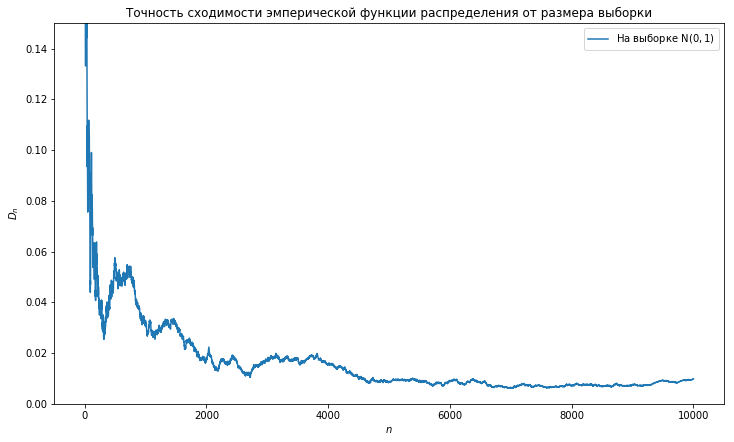

In [8]:
# Размер выборки из условия
n = 10000
# Генерируем выборку
sample = sps.norm.rvs(loc=0, scale=1, size=n)

d_n = D_n(sample)

# Рисуем график
n_s = np.linspace(1, 10000, num=10000)

plt.figure(figsize=(12,7))
plt.title("Точность сходимости эмперической функции распределения от размера выборки")
plt.xlabel('$n$')
plt.ylabel('$D_n$')

plt.plot(n_s, d_n, label='На выборке $\mathsf{N}(0, 1)$')

plt.ylim((0, 0.15))
plt.legend()
plt.show()

**Вывод:**

* По графику видно, что с ростом размера выборки $D_n$ находится близко у нуля. А значит эмперическая функция распределения довольно хорошо приближает истинную. 
* $D_n$ стремится к нулю почти наверное (теорема Гливенко-Кантелли). Таким образом,
эмпирическая функция распределения сходится равномерно к функции распределения.

Такой результат даёт понимание, что эмперическая функция распределения хорошо подходит для оценки функции распределения. А как известно, по функции распределения легко можно восстановить само распределения и его свойства - что и есть основная задача статистики.

**2.** Для $n = 10000$ и $k = 10000$ (значение $k$ можно взять больше) выполните следующее:
    
Вычислите $D_n^1, ... , D_n^k$ для независимых выборок $(X_1^1, ... , X_n^1)$, ... ,$(X_1^k, ... , X_n^k)$ из стандартного нормального распределения. Постройте график гистограммы значений $\sqrt{n} D_n^1, ... , \sqrt{n} D_n^k$ и ядерной оценки плотности распределения этих величин.

Для выполнения задания можно воспользоваться как функцией `seaborn.distplot` (желательно), так и реализацией в `statsmodels`.

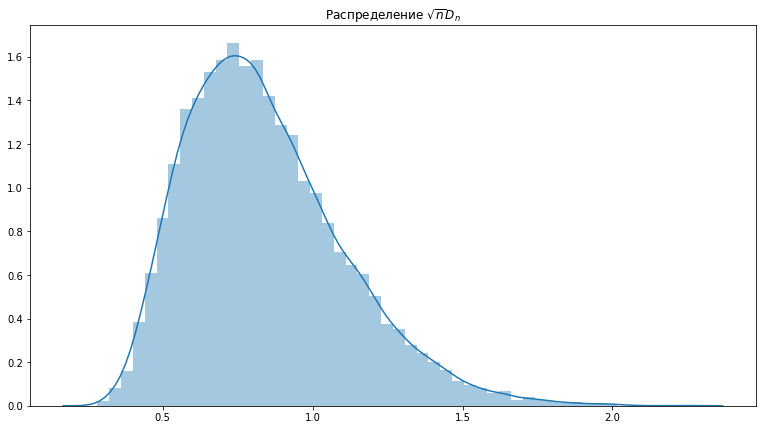

In [9]:
k = 20000
n = 10000

XD = sps.norm.rvs(size=(k, n))
D = D_n(XD, F_ALL=False)

plt.figure(figsize=(13, 7))
plt.title('Распределение $\\sqrt{n}D_n$')
sns.distplot(np.sqrt(n) * D)
plt.show()

**Вывод:**

Получилась горка, похожая на смещённое нормальное распределение

__________________
### Задача 3.
Для каждого распределения постройте график эмпирической функции распределения, гистограмму и график ядерной оценки плотности. 

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [10]:
def draw_ecdf(sample, grid, cdf=None):
    """По сетке grid cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.scatter(sample[:size], np.zeros(size),
                    alpha=0.4, label='sample')
        
        if cdf is not None:
            plt.plot(grid,
                     cdf(grid),
                     color='green', alpha=0.3, lw=2, label='true cdf')
        
        plt.plot(grid,
                 ECDF(sample)(grid),
                 color='red', label='ecdf')
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

In [11]:
def draw_hist(sample, grid, pdf=None):
    """Строит гистограмму и, по сетке grid, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.hist(sample[:size], 
                 bins=20,
                 range=(grid.min(), grid.max()),
                 density=True, label='sample hist')
        
        if pdf is not None:
            plt.plot(grid,
                     pdf(grid),
                     color='green', alpha=0.3, lw=2, label='true pdf')
        
        plt.legend()
    plt.show()

In [12]:
def draw_pdf(sample, grid, pdf=None):
    """По сетке grid cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки
    и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.scatter(sample[:size], np.zeros(size),
                    alpha=0.4, label='sample')
        
        if pdf is not None:
            plt.plot(grid,
                     pdf(grid), color='green', 
                     alpha=0.3, lw=2, label='true pdf')
        
        kde = KDEUnivariate(sample[:size])
        kde.fit(kernel='gau')
        
        plt.plot(grid, kde.evaluate(grid),
                 color='red', label='kde')
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Теперь примените реализованные выше функции к выборкам размера 500 для следующих распределений:

In [13]:
def make_research(distribution, xlims):
    """Обобщённая функция, которая производит
    Сравнение для распределение distribution
    """    
    x0, x1 = xlims
    grid = np.linspace(x0, x1, 1000)
    sample = distribution.rvs(size=500)
    cdf = distribution.cdf
    pdf = distribution.pdf

    draw_ecdf(sample, grid, cdf)
    draw_hist(sample, grid, pdf)
    draw_pdf(sample, grid, pdf)

*1. Равномерное распределение $U[0,1]$*. Графики (ф.р., плотностей) строить на интервале $(-0.2, 1.2)$.

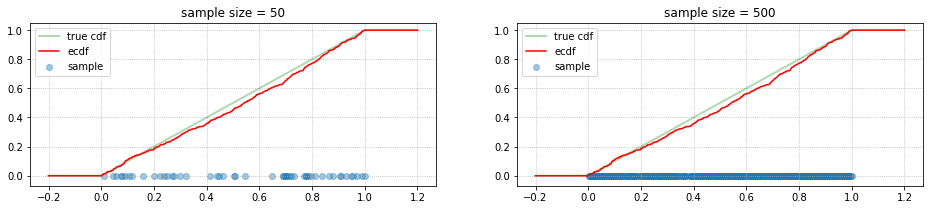

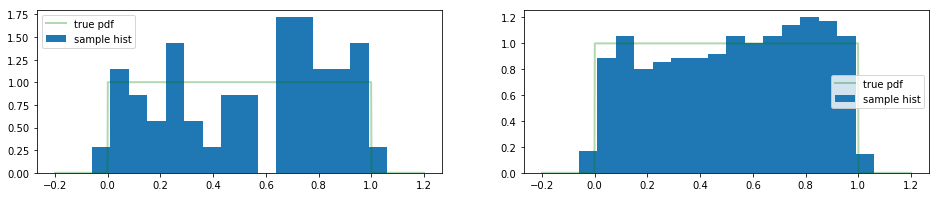

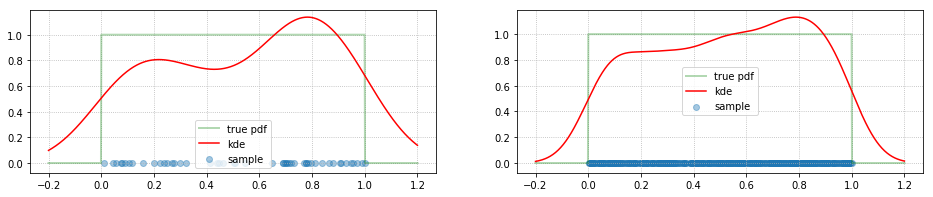

In [14]:
make_research(sps.uniform, [-0.2, 1.2])

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики строить на интервале $(-3, 3)$.

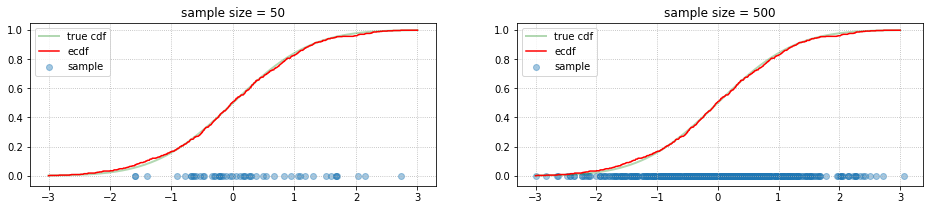

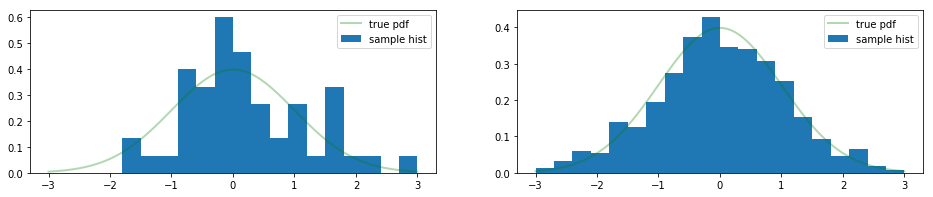

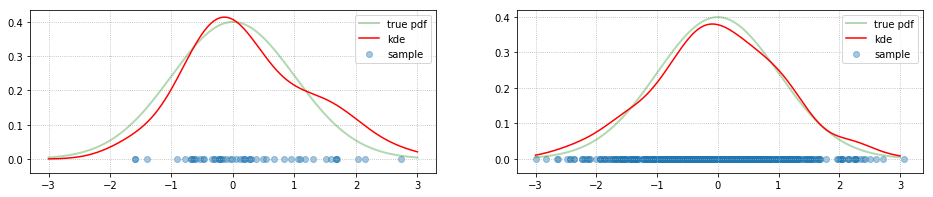

In [15]:
make_research(sps.norm, [-3, 3])

*3. Экспоненциальное распределение $Exp(1)$.* Графики строить на интервале $(-0.5, 5)$.

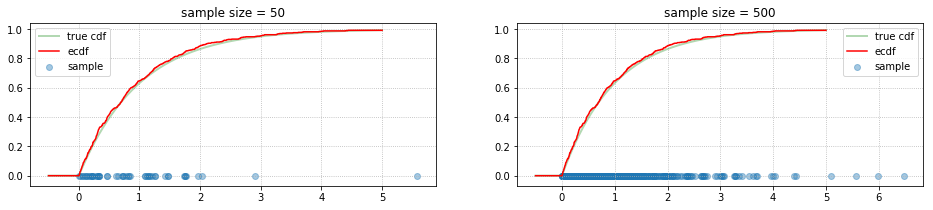

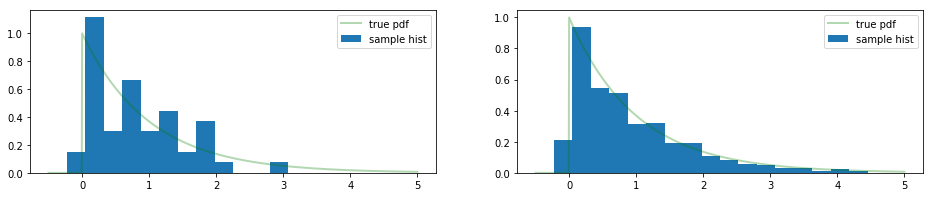

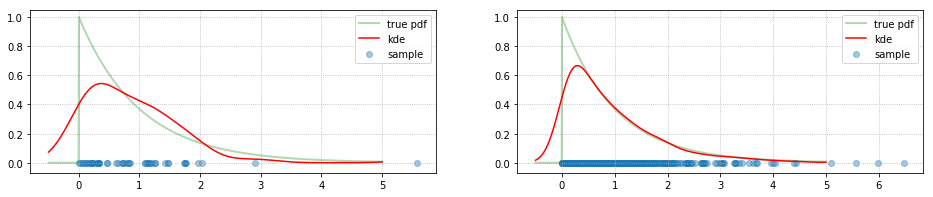

In [16]:
make_research(sps.expon, [-0.5, 5])

**Вывод:**

Можно заметить, что по $1/10$ выборке угадывается распределение, но полученная эмпирическая функция распределения и ядерная оценка плотности имеют резкие скачки и падения, которые выравниваются при росте размера выборки и довольно хорошо оценивают неивестное распределение.

__________________
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

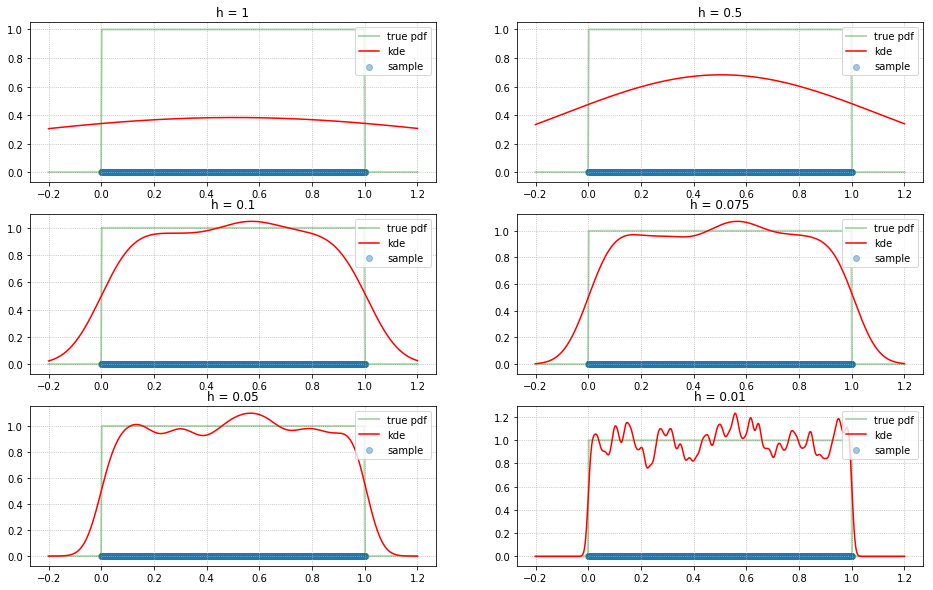

In [17]:
size = 2000
sample = sps.uniform.rvs(size=size)
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(16, 10))
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(kernel="gau", bw=bw)
    
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='sample')
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='true pdf')
    plt.plot(grid, kernel_density.evaluate(grid), 
             color='red', label='kde')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

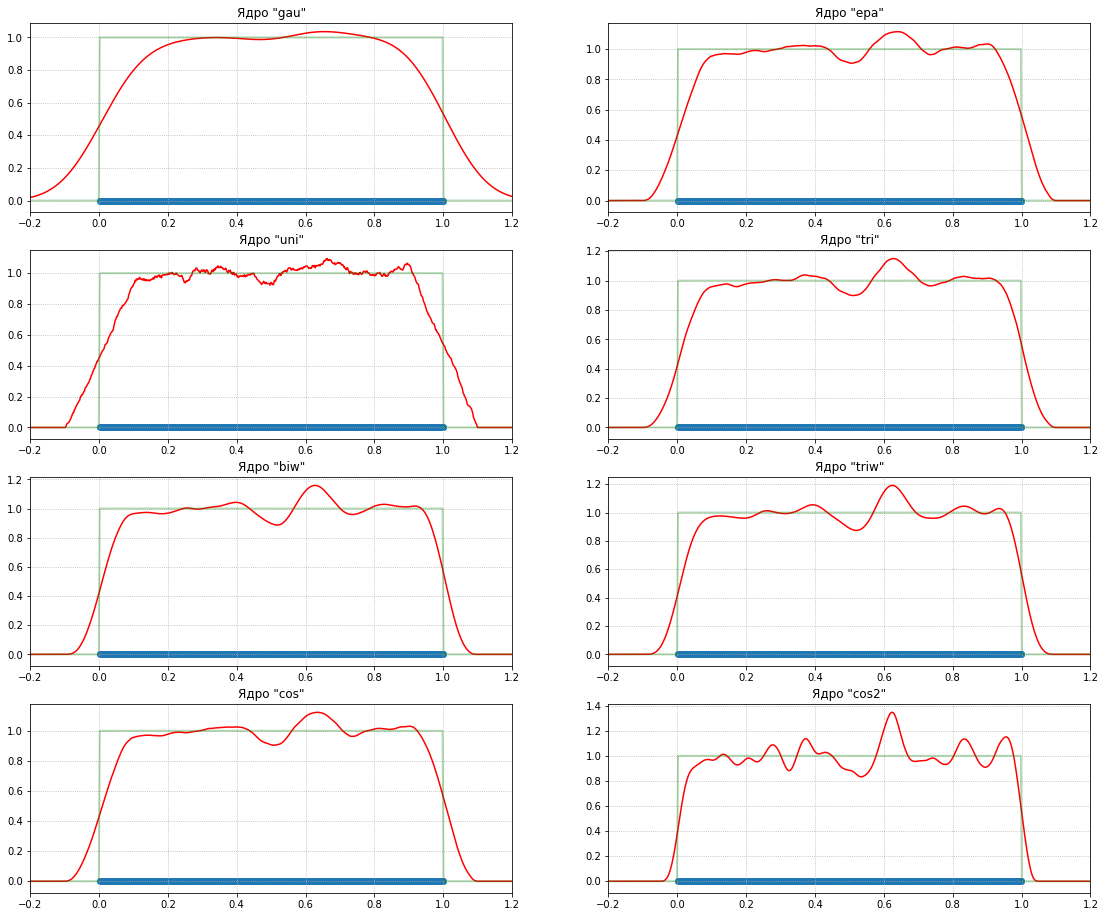

In [18]:
sample = sps.uniform.rvs(size=size)
better_h = 0.1

fig = plt.figure(figsize=(19, 16))
for i, kernel in enumerate(kernel_switch.keys()):
    ax = fig.add_subplot(4, 2, i + 1)
    ax.set_title('Ядро "{}"'.format(kernel))
    
    kernel_density = KDEUnivariate(sample)  # объект, выполняющий построение оценки
    # построение ядерной оценки плотности с заданным ядром
    kernel_density.fit(kernel=kernel, bw=better_h,
                       fft=False, gridsize=2**10)
    
    # отрисовка полученной оценки
    ax.plot(kernel_density.support, kernel_density.density,
             color='red', label='kde')
    # отрисовка выборки
    ax.scatter(sample, np.zeros(size), alpha=0.4, label='sample')
    # Действительная плотность распределения
    ax.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='true pdf')
    
    plt.grid(ls=':')
    ax.set_xlim([-0.2, 1.2])
    

**Вывод:**

Можно заметить, что уже при небольшом размере выборки ($n = 200$), разница ядерных плотностей для разных ядер с одинаковой шириной не так ощутима - получается похожая плотность. А вот к выбору ширины ядра нужно подходить с осторожностью. 

__________________
### Задача 5.

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a> и выберите произвольные 7 столбцов с действительными числами. С помощью `seaborn.PairGrid` постройте таблицу графиков, состоящую из 
* одномерных ядерных оценок плотности по диагонали;
* двумерных ядерных оценок плотности ниже диагонали;
* scatter-plot выше диагонали (`plt.scatter`).

При возникновении затруднений посмотрите обучающий ноутбук по `seaborn`.

In [19]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
column_names = [ 'Alcohol',
                 'Malic acid',
                 'Ash',
                 'Alcalinity of ash',
                 'Magnesium',
                 'Total phenols',
                 'Flavanoids',
                 'Nonflavanoid phenols',
                 'Proanthocyanins',
                 'Color intensity',
                 'Hue',
                 'OD280/OD315 of diluted wines',
                 'Proline']

# Считываем все данные
data = pd.read_csv(url, header=None, names=column_names)

# Выбераем действительные столбцы
need_columns = ["Alcohol",
                "Malic acid",
                "Ash",
                "Magnesium",
                "Flavanoids",
                "Proanthocyanins",
                "Hue"]
wines = data[need_columns]
wines.head()

,Alcohol,Malic acid,Ash,Magnesium,Flavanoids,Proanthocyanins,Hue
1,14.23,1.71,2.43,127,3.06,2.29,1.04
1,13.20,1.78,2.14,100,2.76,1.28,1.05
1,13.16,2.36,2.67,101,3.24,2.81,1.03
1,14.37,1.95,2.50,113,3.49,2.18,0.86
1,13.24,2.59,2.87,118,2.69,1.82,1.04


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/alex-kozinov/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


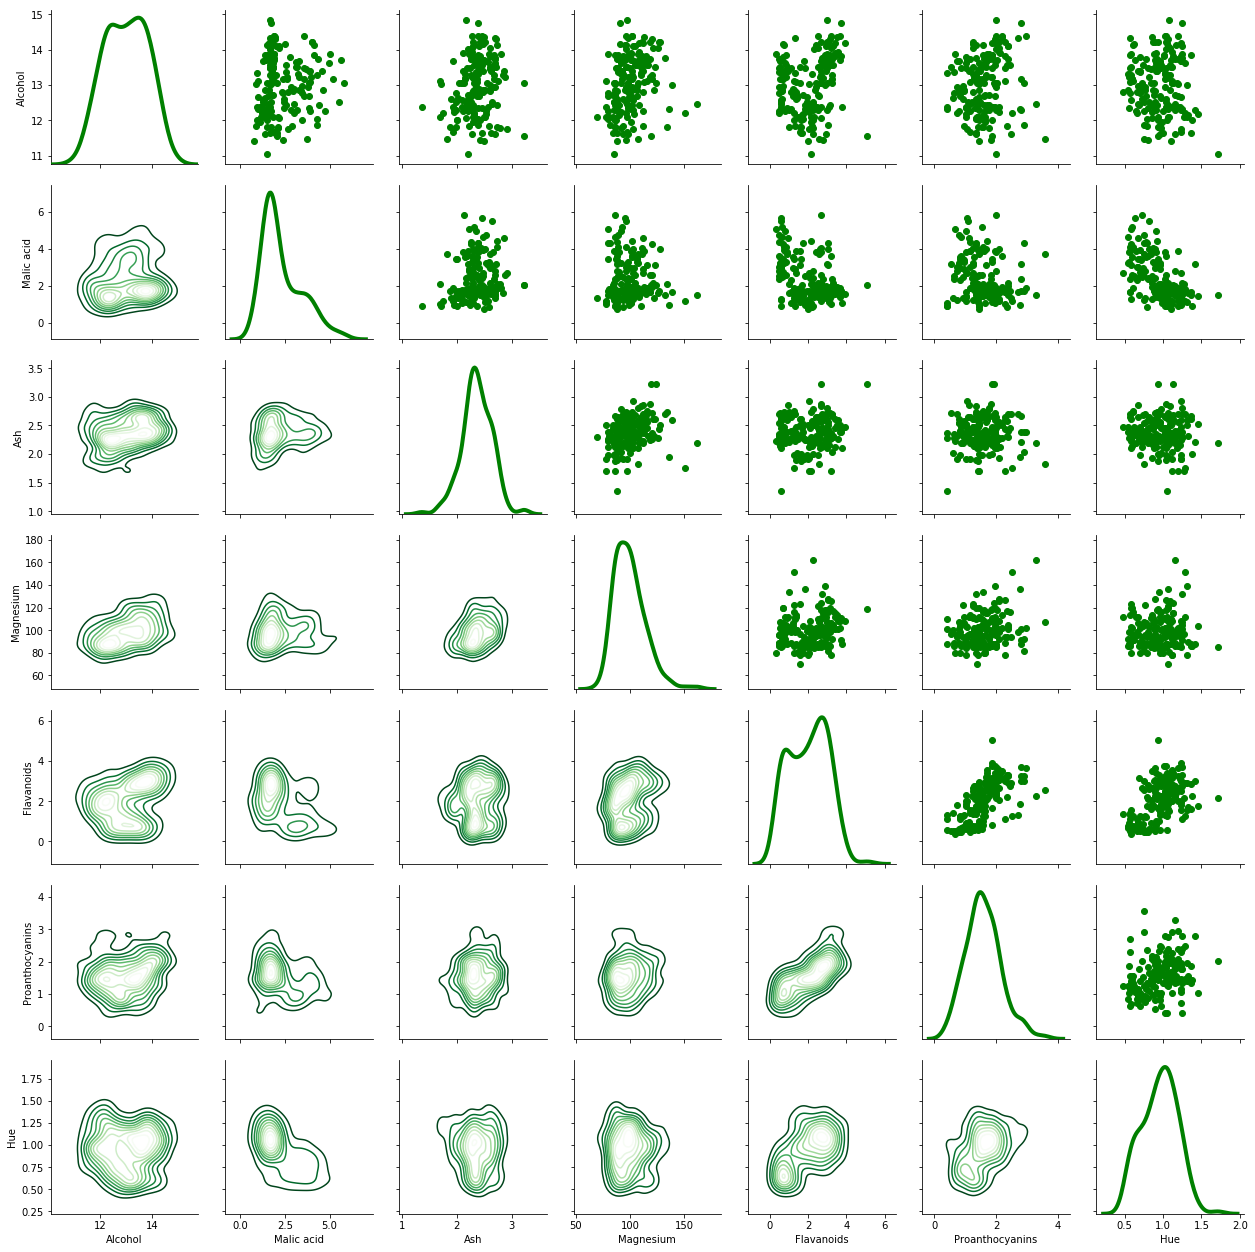

In [20]:
g = sns.PairGrid(wines, diag_sharey=False)
# Отрисовываем одномерные ядерные оценоки плотности
g.map_diag(sns.kdeplot, lw=4, color="Green");
# Отрисовываем двумерные ядерные оценки плотности
g.map_lower(sns.kdeplot, cmap="Greens_r")
g.map_upper(plt.scatter, color="Green")


**Вывод:**

По ядерной плотности на диагонале можно сделать предположение о том, как распределены параметры. Например:
* Alcohol и Flavanoids - похоже на равномерное распределение
* Malic acid и Magnesium - Похоже на экспоненциальное распределение
* Ash и Hue - похоже на нормальное распределение

C помощью точечного изображение можно предположительно оценить число выбросов
А с помощью двумерных плотностей можно задуматься о зависимости между признаками 

__________________
### Задача 6.

Около месяца назад (24-25 октября) в Краснодарском крае сильные ливни привели наводнению, из-за которого сильно пострадали города Сочи и Туапсе. Вам выданы данные об уровне воды за 2014-2018 год по следующим рекам Краснодарского края:
* Мзымта (Сочи, Адлерский район, Роза Хутор)
* Сочи (Сочи, Центральный район)
* Туапсе (Туапсе)
* Херота (Сочи, Адлерский район)
* Хоста (Сочи, Хостинский район)

В файлах используйте столбец `Уровень воды (по БСВ)`. Это уровень воды по <a href="https://ru.wikipedia.org/wiki/Балтийская_система_высот">Балтийской системе высот</a> — принятой в СССР системе нормальных высот, отсчёт которых ведётся от нуля Кронштадтского футштока. Для каждой реки нарисуйте график уровня воды.

Данные собранны за каждые 10 минут, что достаточно тяжело обрабатывать. Преобразуйте данные, рассмотрев максимальное значение уровня воды за сутки.
Вам нужно по данным до октября 2018 года не включительно построить верхнюю границу предсказательного интервала уровня воды и сравнить ее с максимальным значением, достигавшимся в октябре 2018 года. 

Предсказательный интервал постройте в три этапа:
1. Бутстрепный доверительный интервал для среднего значения максимального уровня воды за сутки;
2. Бутстрепный доверительный интервал для стандартного отклонения максимального уровня воды за сутки;
3. Сложите границу доверительного интервала для среднего с границей доверительного интервала для стандартного отклонения, домноженной на 2.

Рассмотрите три способа построения бутстрепных доверительный интервалов, рассказанные на лекции.

Сделайте выводы.

In [21]:
<...>

SyntaxError: invalid syntax (<ipython-input-21-9f7489d2218b>, line 1)

## Проверка статистических гипотез

__________________
### Задача 7.
Существует примета, что если перед вам дорогу перебегает черный кот, то скоро случится неудача. 
Вы же уже достаточно хорошо знаете статистику и хотите проверить данную примету. 
Сформулируем задачу на математическом языке. 

Пусть $X_1, ..., X_n \sim Bern(p)$ --- проведенные наблюдения, где $X_i = 1$, если в $i$-м испытании случилась неудача после того, как черный кот перебежал дорогу, а $p$ --- неизвестная вероятность такого события. 
Вы хотите проверить гипотезу $\mathsf{H}_0\colon p=1/2$ (отсутствие связи между черным котом и неудачей) против альтернативы $\mathsf{H}_1\colon p>1/2$ (неудача происходит чаще если черный кот перебегает дорогу).

Известно, что $S = \left\{T(X) \geqslant c_\alpha\right\}$, где $T(X) = \sum X_i$, является равномерно наиболее мощным критерием для проверки этих гипотез. 
Чему при этом равно $c_\alpha$ и как определяется p-value?

* $c_\alpha$ определим как $1-\alpha$-квантиль распределения $Bin(n, 0.5)$, так как статистика $T(X)$ имеет биноминальное распределение $Bin(n, \theta)$
* Определим p-value как вероятность того, что статистика экстремальнее, чем статистика выборки $\mathscr{X}$, если верна основная гипотиза с $p = 1/2$: 
$$
p\left(\mathscr{X}\right) = \mathsf{P}\left(T(X) > T\left(\mathscr{X}\right)\right)
$$


Для начала проверьте, что критерий работает.
Возьмите несколько значений $n$ и реализаций статистики $T(X)$.
В каждом случае найдите значение $c_\alpha$ и p-value.
Оформите это в виде таблицы (можно через `pandas.DataFrame`).

Пользуйтесь функциями из `scipy.stats`. Внимательно проверьте правильность строгих и нестрогих знаков.

In [22]:
n_s = [5, 10, 20, 30, 100]
alpha = 0.05
data = []

for n in n_s:
    X = sps.bernoulli(p=0.5).rvs(size=n)
    T = X.sum()
    c_alpha = sps.binom(n=n, p=0.5).ppf(1 - alpha)
    p_value = sps.binom(n, 0.5).sf(T)
    data.append([T, c_alpha, p_value])
    
pd.DataFrame(data=data, columns=['$t$', '$c_{\\alpha}$', 'p-value'])

,$t$,$c_{\alpha}$,p-value
0,4,4.0,0.031250
1,7,8.0,0.054688
2,12,14.0,0.131588
3,13,19.0,0.707668
4,40,58.0,0.971556


Для каких истинных значений $p$ с точки зрения практики можно считать, что связь между черным котом и неудачей есть? 

* На практике кажется, что при $p$ чуть большемот $1/2$, ведь  в действительности $p$ не может быть равна строго $1/2$ и поэтому связим может не быть в некоторой окрестности $1/2$

Теперь сгенерируйте 10 выборок для двух случаев: 1). $n=5, p=0.75$; 2). $n=10^5, p=0.51$. 
В каждом случае в виде таблицы выведите реализацию статистики $T(X)$, соответствующее p-value и 0/1 -- отвергается ли $\mathsf{H}_0$ (выводите 1, если отвергается).

In [23]:
def check_conjecture(n, p):
    """ генерирует k выборок и проверяем 
    отвергаемость гипотиы H_0 с помощью
    p-value
    """
    k = 10
    X = sps.bernoulli(p=p).rvs(size=(k, n))
    T = X.sum(axis=1)
    p_value = sps.binom(n, 0.5).sf(T)

    d_f = pd.DataFrame({
        '$t$' : T,
        'p_value' : p_value
    })
    d_f['$H_0$ Отвергается' ] =  p_value < alpha
    return d_f

In [24]:
check_conjecture(5, 0.75)

,$t$,p_value,$H_0$ Отвергается
0,4,0.03125,True
1,5,0.00000,True
2,3,0.18750,False
3,3,0.18750,False
4,2,0.50000,False
5,4,0.03125,True
6,1,0.81250,False
7,4,0.03125,True
8,3,0.18750,False
9,3,0.18750,False


In [25]:
check_conjecture(10**5, 0.51)

,$t$,p_value,$H_0$ Отвергается
0,51237,2.497644e-15,True
1,51161,1.018880e-13,True
2,50873,1.650857e-08,True
3,50746,1.171339e-06,True
4,50762,7.086266e-07,True
5,50878,1.378080e-08,True
6,51055,1.229347e-11,True
7,51018,5.904135e-11,True
8,50829,7.757750e-08,True
9,50989,1.945402e-10,True


**Вывод:**

Можно заметить две забавной закономерности, связывающие размер выбоки и истинную вероятность:
* При малом размере выборки, гипотеза не всегда отвергается, даже когда истинная вероятность явно указывает, что связь между несчастьями и чёрными котиками есть
* При большом размере выборки, гипотеза всегда отвергается, хотя реальная вероятность выбрана чуть больше $1/2$, что вполне допустимо в повседневности.


Возникает задача подбора оптимального размера выборки.

Для этого сначала зафиксируйте значение $p^* > 1/2$, которое будет обладать следующим свойством.
Если истинное $p > p^*$, то такое отклонение от $1/2$ с практической точки зрения признается существенным, то есть действительно чаще случается неудача после того, как черный кот перебегает дорогу.
В противном случае отклонение с практической точки зрения признается несущественным.

Теперь для некоторых $n$ постройте графики функции мощности критерия при $1/2 < p < 1$ и уровне значимости 0.05.
Выберите такое $n^*$, для которого функция мощности дает значение 0.8 при $p^*$.

* Возьму вполне реальное значение $p^* = 0.75$

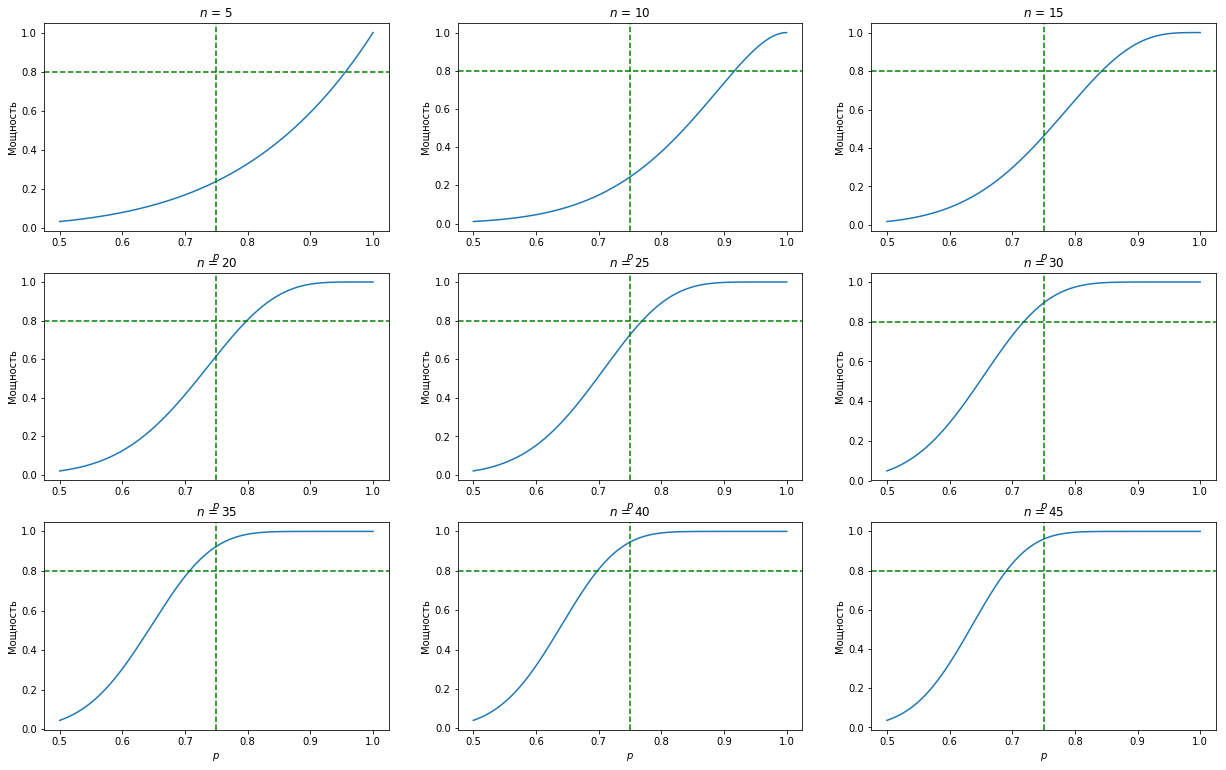

In [26]:
def power(p, n):
    # считаем c_alpha для критерия проверки
    c_alpha = sps.binom(n=n, p=0.5).ppf(1 - alpha)
    # Возвращаем вероятность того, что отвергаем при \theta = p
    return sps.binom(n=n, p=p).sf(c_alpha)

p_z = 0.75
need_power = 0.8

n_list = [5, 10, 15, 20, 25, 30, 35, 40, 45]
p_grid = np.linspace(0.5, 1, 900)

plt.figure(figsize=(21, 13))

for i, n in enumerate(n_list):
    plt.subplot(3, 3, i + 1)
    plt.title('$n$ = {}'.format(n))
    plt.xlabel('$p$')
    plt.ylabel('Мощность')
    
    plt.plot(p_grid, power(p_grid, n))
    plt.axvline(p_z, ls='--', color='g', label="$p^*$")
    plt.axhline(need_power, ls='--', color='g', label="$p^*$")
    
    
plt.show()

* Лучше всего подходит $n^* = 25$

Для выбранного $n^*$ проведите эксперимент, аналогичный проведенным ранее экспериментам, сгенерировав выборки для следующих истинных значений $p$: 1). $1/2 < p < p^*$; 2). $p > p^*$.

In [27]:
n_z = 25

In [28]:
# Берём в качестве p середину [0.5, p*]
check_conjecture(n_z, 0.62)

,$t$,p_value,$H_0$ Отвергается
0,18,0.007317,True
1,17,0.021643,True
2,18,0.007317,True
3,15,0.114761,False
4,14,0.212178,False
5,16,0.053876,False
6,12,0.500000,False
7,12,0.500000,False
8,16,0.053876,False
9,11,0.654981,False


In [29]:
# Берём в качестве p середину [p*, 1]
check_conjecture(n_z, 0.87)

,$t$,p_value,$H_0$ Отвергается
0,22,9.715557e-06,True
1,23,7.748604e-07,True
2,21,7.826090e-05,True
3,20,4.552603e-04,True
4,25,0.000000e+00,True
5,20,4.552603e-04,True
6,24,2.980232e-08,True
7,21,7.826090e-05,True
8,23,7.748604e-07,True
9,23,7.748604e-07,True


**Вывод:**

Во время проверок гипотиз нужно быть очень осторожным с размером выборок и держать баланс:
* При достаточно малом размере могут приниматься явно неверные гипотизы
* А при больших размерах может повышаться точность $c_{\alpha}$, тем самым отклоняться гипотезы, которые находятся в допустимой области 

__________________
### Задача 8.
В Долгопрудном крупная торговая сеть Y10 имеет $100$ магазинов и планирует открыть еще $5$ магазинов. Сеть Y10 считает магазин успешным, если его дневная выручка в $27$ днях из $30$ превышает некоторый установленный порог. Благодаря модели машинного обучения, обученной на предыдущих $100$ магазинах, было выбрано 5 потенциальных точек, в которых и решено было открыть новые магазины. 

Вам предоставлена чистая выручка по каждому из $5$ магазинов за день в течении трех месяцев ($31 + 30 + 31$ день) работы этих пяти магазинов. Считается, что магазин успешен в течении дня, если его выручка за этот день превышает $50000$ рублей. По этому правилу сопоставьте каждому магазину набор бернуллиевских случайных величин, которе принимают значение $1$, если магазин успешен в течении дня. Для простоты будем считать, что выручка за день не зависит от аналогичных показателей за предыдущие дни, и ее распределение не меняется во времени, то есть данные образуют выборку.

Модель машинного обучения выдает также параметры для априорного бета-распределения распределения по каждому из магазинов:
1. $Beta(1, 1)$;
2. $Beta(2900, 100)$;
3. $Beta(29, 1)$;
4. $Beta(29, 1)$;
5. $Beta(1, 1)$.

Проанализируйте данные и ответьте на следующие вопросы.
1. Для каких из магазинов можно утверждать, что с вероятностью $0.95$ их можно считать успешными? Для ответа на этот вопрос нужно выполнить байесовскую проверку гипотез $\mathsf{H}_0\colon\ p=27/30\ vs.\ \mathsf{H}_1\colon\ p>27/30$, посчитав апостериорную вероятность события $\{p>27/30\}$. Если эта вероятность не меньше $0.95$, магазин можно считать успешным.
2. Про какие из магазинов можно сказать, что их лучше закрыть? Закрывать магазин затратно, для этого он должен быть убыточным в $27$ днях из $30$. Для ответа на этот вопрос нужно выполнить байесовскую проверку гипотез $\mathsf{H}_0\colon\ p=3/30\ vs.\ \mathsf{H}_1\colon\ p<3/30$, посчитав апостериорную вероятность события $\{p<3/30\}$. Если эта вероятность не меньше $0.95$, магазин можно закрыть.
3. Что можно сказать об остальных магазинах?
4. Выполнены ли предположения модели на практике? Имеет ли смысл собирать данные сразу после открытия магазина?

In [ ]:
<...>

**Вывод:**

<...>